四辺に接してる画像を取り除く

In [3]:
import glob
import os
import shutil

In [12]:
infolder="D:\ex\data\ID_all_except_multiple"
outfolder="D:\ex\data\ID_all_except_cutoff_except_multiple"
touched_on_all_foursides_folder="D:\ex\data\ID_all_cutoff_except_multiple"

top
bottom
left
right

四辺に接しているかどうか
しきい値　95%に収まっているか

In [13]:
for inpath in glob.glob(os.path.join(infolder, "*")):
    if "txt" in inpath:
        with open(inpath) as f:
            yolo_txt = f.readlines()
            if len(yolo_txt) != 1:
                print("len(yolo_txt) != 1")
                print(inpath)
            
            yolo_txt_splits = yolo_txt[0].split() #yolo_txtの1行目を分割する[
            x = float(yolo_txt_splits[1])
            y = float(yolo_txt_splits[2])
            width = float(yolo_txt_splits[3])
            height = float(yolo_txt_splits[4])

            top = y - height/2
            bottom = y + height/2
            left = x - width/2
            right = x + width/2

            folderpath, txt_path = os.path.split(inpath)
            imgpath = os.path.join(folderpath,os.path.splitext(txt_path)[0] + '.jpg')
            if top < 0.05 or bottom > 1 - 0.05 or left < 0.05 or right > 1 - 0.05: # This is touched on all four sides
                shutil.copy(imgpath, touched_on_all_foursides_folder)
            else:
                shutil.copy(imgpath,outfolder)
                shutil.copy(inpath,outfolder)

yolo形式のアノテーション情報で画像をトリミングする
ここでグレーに変換する

In [1]:
import cv2

In [ ]:
infolder = "D:\ex\data\ID_all_except_cutoff_except_multiple0.05"
outfolder = "D:\ex\data\\all_yolo_trim"

for inpath in glob.glob(os.path.join(infolder, "*")):
    if "txt" in inpath:
        with open(inpath) as f:
            yolo_txt = f.readlines()
            if len(yolo_txt) != 1: #yolo形式アノテーションが2行以上ないかチェック
                print("len(yolo_txt) != 1")
                print(inpath)
            

            yolo_txt_splits = yolo_txt[0].split() #yolo_txtの1行目を分割する
            detect_x = float(yolo_txt_splits[1])
            detect_y = float(yolo_txt_splits[2])
            detect_width = float(yolo_txt_splits[3])
            detect_height = float(yolo_txt_splits[4])

            imgpath = os.path.join(infolder,os.path.splitext(inpath)[0] + '.jpg')
            img = cv2.imread(imgpath, 0)
            img_height, img_width = img.shape

            detect_top_coordinate = round(img_height * (detect_y - detect_height/2))
            detect_bottom_coordinate = round(img_height * (detect_y + detect_height/2))
            detect_left_coordinate = round(img_width * (detect_x - detect_width/2))
            detect_right_coordinate = round(img_width * (detect_x + detect_width/2))

            print(f"Object coordinates: Top({detect_top_coordinate}), Bottom({detect_bottom_coordinate}), Left({detect_left_coordinate}), Right({detect_right_coordinate})")

            trim = img[detect_top_coordinate:detect_bottom_coordinate, detect_left_coordinate:detect_right_coordinate]
            if trim.size == 0:
                print("Error: Cropped image is empty.")
            else:
                img_basename = os.path.basename(imgpath)
                if not cv2.imwrite(os.path.join(outfolder, img_basename), trim):
                    print(f"Error: Unable to save image at '{os.path.join(outfolder, img_basename)}'.")
                else:
                    print(f"Image successfully saved at '{os.path.join(outfolder, img_basename)}'.")

yolo_trim_allを間引きする
いったん10枚ごとに

In [1]:
import os

# 作成するディレクトリ名をリストに格納
folders = [
    "all_images",
    "egg",
    "egg_low_grade",
    "invisible",
    "indistinguishable",
    "out_of_focus",
]

# ベースディレクトリ名を指定
base_directory = "D:\ex\data\yolo_trim_every10extracted"

# ベースディレクトリを作成
os.makedirs(base_directory, exist_ok=True)

# 各サブディレクトリを作成
for folder in folders:
    subdir_path = os.path.join(base_directory, folder)
    os.makedirs(subdir_path, exist_ok=True)

print("ディレクトリ構成が作成されました。")

ディレクトリ構成が作成されました。


In [2]:
import os
import shutil

source_directory = "D:\\ex\\data\\yolo_trim_all"
destination_directory = "D:\\ex\\data\\yolo_trim_every10extracted\\all_images"

# 画像が10枚おきに抽出されるようにするためのカウンタ
counter = 0

# コピー先のディレクトリを作成
os.makedirs(destination_directory, exist_ok=True)

# 画像ファイルを一覧表示
for filename in os.listdir(source_directory):
    # ファイルが画像であることを確認（拡張子が.jpg, .jpeg, .pngの場合）
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # カウンタが10の倍数の場合、画像をコピー
        if counter % 10 == 0:
            source_path = os.path.join(source_directory, filename)
            destination_path = os.path.join(destination_directory, filename)
            shutil.copy2(source_path, destination_path)
        # カウンタをインクリメント
        counter += 1

print("画像が10枚おきに抽出されました。")

画像が10枚おきに抽出されました。


In [ ]:
import os
import cv2
import shutil
import numpy as np

source_directory = "D:\\ex\\data\\yolo_trim_all"
destination_directory = "D:\\ex\\data\\yolo_trim_every10extracted\\all_images"

# 類似度の閾値（0.0から1.0の範囲で設定）
similarity_threshold_1 = 0.98
similarity_threshold_2 = 0.90

# 類似度を計算する関数
def calculate_similarity(image1, image2):
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    return np.mean(image1_gray == image2_gray)

os.makedirs(destination_directory, exist_ok=True)

# 画像ファイル名を取得し、連番画像順に並べ替える
image_files = [file for file in os.listdir(source_directory) if file.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

prev_image = None
counter = 0

for index, filename in enumerate(image_files):
    source_path = os.path.join(source_directory, filename)
    current_image = cv2.imread(source_path)

    # 前の画像が存在する場合、類似度を計算
    if prev_image is not None:
        similarity = calculate_similarity(prev_image, current_image)

        # 類似度が閾値1より高い場合（変化が非常に小さい）、より多く間引く
        if similarity >= similarity_threshold_1:
            if counter % 30 == 0:
                destination_path = os.path.join(destination_directory, filename)
                shutil.copy2(source_path, destination_path)
            counter += 1

        # 類似度が閾値2より高い場合（変化が小さい）、多く間引く
        elif similarity >= similarity_threshold_2:
            if counter % 20 == 0:
                destination_path = os.path.join(destination_directory, filename)
                shutil.copy2(source_path, destination_path)
            counter += 1

        # 類似度が閾値2より低い場合（変化が大きい）、10枚おきに画像をコピー
        else:
            if counter % 10 == 0:
                destination_path = os.path.join(destination_directory, filename)
                shutil.copy2(source_path, destination_path)
            counter += 1

    # 最初の画像はコピー
    else:
        destination_path = os.path.join(destination_directory, filename)
        shutil.copy2(source_path, destination_path)
        counter += 1

    prev_image = current_image

print("画像が類似度に基づいて間引かれました。")

100%|██████████| 3541/3541 [07:24<00:00,  7.97it/s]


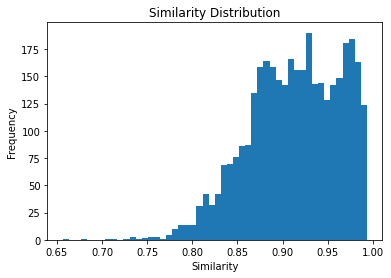

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

source_directory = "D:\\ex\\data\\yolo_trim_all"

# 類似度を計算する関数
def calculate_similarity(image1, image2):
    # 画像が同じサイズでない場合、リサイズする
    if image1.shape != image2.shape:
        height, width = image1.shape[:2]
        image2 = cv2.resize(image2, (width, height))
    return ssim(image1, image2)

# 画像ファイル名を取得し、連番画像順に並べ替える
image_files = [file for file in os.listdir(source_directory) if file.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

prev_image = None
similarities = []

# 進捗バーを表示するためにtqdmを使用
for index, filename in tqdm(enumerate(image_files), total=len(image_files)):
    source_path = os.path.join(source_directory, filename)
    current_image = cv2.imread(source_path, 0)

    if prev_image is not None:
        similarity = calculate_similarity(prev_image, current_image)
        similarities.append(similarity)

    prev_image = current_image

plt.hist(similarities, bins=50)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution')
plt.show()

In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm

source_directory = "D:\\ex\\data\\yolo_trim_all"
output_directory = "D:\\ex\\data\\yolo_trim_extracted"

os.makedirs(output_directory, exist_ok=True)

def calculate_similarity(image1, image2):
    if image1.shape != image2.shape:
        height, width = image1.shape[:2]
        image2 = cv2.resize(image2, (width, height))

    return ssim(image1, image2)

image_files = [file for file in os.listdir(source_directory) if file.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

prev_image = None
similarities = []

# 類似度を計算
for index, filename in tqdm(enumerate(image_files), total=len(image_files)):
    source_path = os.path.join(source_directory, filename)
    current_image = cv2.imread(source_path, 0)

    if prev_image is not None:
        similarity = calculate_similarity(prev_image, current_image)
        similarities.append(similarity)

    prev_image = current_image

# 類似度の平均を計算
avg_similarity = np.mean(similarities)

prev_image = None
extraction_frequency = 10

# 抽出頻度を調整して画像を保存
for index, filename in tqdm(enumerate(image_files), total=len(image_files)):
    source_path = os.path.join(source_directory, filename)
    current_image = cv2.imread(source_path)

    if prev_image is not None:
        current_similarity = calculate_similarity(prev_image, current_image)

        # 現在の類似度が全体の平均類似度より高い場合、抽出頻度を増やす
        if current_similarity > avg_similarity:
            extraction_frequency = 15
        # 低い場合、抽出頻度を減らす
        else:
            extraction_frequency = 5

        # 抽出頻度に応じて画像を保存
        if index % extraction_frequency == 0:
            output_path = os.path.join(output_directory, filename)
            cv2.imwrite(output_path, current_image)

    prev_image = current_image

  0%|          | 1/3541 [00:00<00:21, 166.72it/s]


error: OpenCV(4.7.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x981fb336::Set<1,-1,-1>,struct cv::impl::A0x981fb336::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1
